In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator
from scipy.optimize import curve_fit

In [3]:
def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister, angle) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ########## your code goes here #######

    ##1 Initialization

    q0, q1 = qr
    # apply Hadamard on the auxiliary qubit
    qc.h(q0)
    # put the system qubit into the |1> state
    qc.x(q1)

    ##2 Apply control-U operator as many times as needed to get the least significant phase bit

    # we want to apply controlled-S 2^k times
    k = 0
    # calculate the angle of CPhase corresponding to 2^k applications of angle
    cphase_angle = angle * 2**k
    # apply the controlled phase gate
    qc.cp(cphase_angle, q0, q1)

    ##3 Measure the auxiliary qubit in x-basis into the first classical bit

    # apply Hadamard to change to the X basis
    qc.h(q0)
    # measure the auxiliary qubit into the first classical bit
    c0 = cr
    qc.measure(q0, c0)

    return qc


def iqpe(angle: float, steps: int, bits_list = []):
    if steps == 1:
        qr = QuantumRegister(2, "q")
        cr = ClassicalRegister(1, "c")
        return step_1_circuit(qr,cr,angle)                  #funktioniert!!!
    else:
        qr = QuantumRegister(2,"q")
        cr = ClassicalRegister(steps, "c")
        q0, q1 = qr

        list = []
        for i in range(97, 97+steps):                               #hier die Liste mit dem Classical Register
            list.append("{:c}".format(i))
        list = cr
        qc = QuantumCircuit(qr,cr)

        # apply Hadamard on the auxiliary qubit
        if not bits_list:                                                                                           #"Normaler" QPE-Circuit
            qc.h(q0)
            # put the system qubit into the |1> state
            qc.x(q1)
            ##2 Apply control-U operator as many times as needed to get the least significant phase bit
            # we want to apply controlled-S 2^k times
            k = steps-1
            # calculate the angle of CPhase corresponding to 2^k applications of angle
            cphase_angle = angle * 2**k
            # apply the controlled phase gate
            qc.cp(cphase_angle, q0, q1)
            ##3 Measure the auxiliary qubit in x-basis into the first classical bit
            # apply Hadamard to change to the X basis
            qc.h(q0)
            # measure the auxiliary qubit into the first classical bit                   
            qc.measure(q0, list[0])

            for i in range(1,steps):                                                                                                   
                qc.reset(q0)
                # apply Hadamard on the auxiiliary qubit
                qc.h(q0)

                ##2 Apply phase correction conditioned on the first classical bit

                for j in range(i):
                    with qc.if_test((list[j], 1)):
                        qc.p((-2*np.pi)/(2**(i-j+1)), q0)

                ##3 Apply control-U operator as many times as needed to get the next phase bit

                # we want to apply controlled-S 2^k times
                k = steps - i - 1
                # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
                cphase_angle = angle * 2**k
                # apply the controlled phase gate
                qc.cp(cphase_angle, q0, q1)

                ##4 Measure the auxiliary qubit in x-basis into the second classical bit

                # apply Hadamard to change to the X basis
                qc.h(q0)
                # measure the auxiliary qubit into the first classical bit
                qc.measure(q0, list[i])
            
            return qc

        else:
            qc.x(q1)
            for j in range(len(bits_list)):
                qc.reset(q0)
                if bits_list[j] == "1":
                    qc.x(q0)
                    qc.measure(q0, list[j])


        qc.reset(q0)
        # apply Hadamard on the auxiiliary qubit
        qc.h(q0)

        ##2 Apply phase correction conditioned on the first classical bit

        for j in range(steps-1):
            if bits_list[j] == "1":
                qc.p((-2*np.pi)/(2**(steps-j)), q0)
            # with qc.if_test((list[j], 1)):
            #     qc.p((-2*np.pi)/(2**(i-j+1)), q0)

        # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
        cphase_angle = angle
        # apply the controlled phase gate
        qc.cp(cphase_angle, q0, q1)

        ##4 Measure the auxiliary qubit in x-basis into the second classical bit

        # apply Hadamard to change to the X basis
        qc.h(q0)
        # measure the auxiliary qubit into the first classical bit
        qc.measure(q0, list[steps-1])
        
        return qc
#Funktioniert

def iqpe_improved(angle: float, shots_per_it: list):                            #Länge der Liste gibt mir meine depth bzw. #Iterationen
    bits_list=[]
    if  len(shots_per_it) == 1:
        qr = QuantumRegister(2, "q")
        cr = ClassicalRegister(1, "c")
        return step_1_circuit(qr,cr,angle)                  #funktioniert!!!
    else:
        steps = len(shots_per_it) + 1
        qr = QuantumRegister(2,"q")
        cr = ClassicalRegister(1, "c")
        q0, q1 = qr

        list = []
        list.append("c0")
        list = cr

        qc = QuantumCircuit(qr,cr)

        # apply Hadamard on the auxiliary qubit                                             
        qc.h(q0)
        # put the system qubit into the |1> state
        qc.x(q1)
        ##2 Apply control-U operator as many times as needed to get the least significant phase bit
        # we want to apply controlled-S 2^k times
        k = steps-1
        # calculate the angle of CPhase corresponding to 2^k applications of angle
        cphase_angle = angle * 2**k
        # apply the controlled phase gate
        qc.cp(cphase_angle, q0, q1)
        ##3 Measure the auxiliary qubit in x-basis into the first classical bit
        # apply Hadamard to change to the X basis
        qc.h(q0)
        # measure the auxiliary qubit into the first classical bit                                    
        qc.measure(q0, list[0])                                                                                                     #Bis hier, nur step_1_circuit
        sim = AerSimulator()
        job = sim.run(qc, shots=shots_per_it[0])
        result = job.result()
        counts = result.get_counts()
        print("Counts vom ersten Bit: ", counts)
        max_val = max(counts.values())
        max_keys = []
        for key in counts:
            if counts[key] == max_val:
                max_keys.append(key)
        chosen_one = max_keys[0]
        bits_list.append(chosen_one)

        for i in range(1,steps-1):                                                                                                    #Ab hier, gehts weiter über die for schleife
            qr = QuantumRegister(2,"q")
            cr = ClassicalRegister(1, "c")
            q0, q1 = qr
            list = []
            list.append("c0")
            list = cr
            qc = QuantumCircuit(qr,cr)

            # if bits_list[i-1] == "1":
            #     qc.x(q0)

            # apply Hadamard on the auxiiliary qubit
            qc.h(q0)
            qc.x(q1)
            ##2 Apply phase correction conditioned on the first classical bit
            for j in range(i):
                if bits_list[j] == "1":
                    qc.p((-2*np.pi)/(2**(i-j+1)), q0)
            ##3 Apply control-U operator as many times as needed to get the next phase bit
            # we want to apply controlled-S 2^k times
            k = steps - i - 1
            # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
            cphase_angle = angle * 2**k
            # apply the controlled phase gate
            qc.cp(cphase_angle, q0, q1)
            ##4 Measure the auxiliary qubit in x-basis into the second classical bit
            # apply Hadamard to change to the X basis
            qc.h(q0)
            # measure the auxiliary qubit into the first classical bit
            qc.measure(q0, list[0])
            sim = AerSimulator()
            job = sim.run(qc, shots=shots_per_it[i])
            result = job.result()
            counts = result.get_counts()
            max_val = max(counts.values())
            max_keys = []
            for key in counts:
                if counts[key] == max_val:
                    max_keys.append(key)
            chosen_one = max_keys[0]
            bits_list.append(chosen_one)
            print("Die Counts von den anderen Bits: ", counts)
        print("Das ist die bits_list: ", bits_list)
        return iqpe(angle, steps , bits_list)

#Funktioniert
def convert(bin: str):                  #konvertiert den bitstring in deciaml, e.g. 0110 = 0.375
    k = list(bin)
    a = [int(i) for i in k]
    n = 0
    for i in range(len(a)):
        if a[i] == 1:
            n += 1/2**(i+1)
    return n
#Funktioniert

def mean(x: list, y: list):                 #bildet den Mittelwert unter den Shots einer Messung
    m = 0
    total = 0
    for i in range(len(x)):
        m += x[i]*y[i]
        total += y[i]
    m = m*(1/total)
    return m
#Funktioniert

def closest_bin(n: float, prec: int):
    closest = 10
    steps = 2**(-prec)
    bin_list = [i*steps for i in range(2**prec)]
    for i in bin_list:
        if np.abs(n - i) < np.abs(closest-n):
            closest = i
    return closest
#Funktioniert

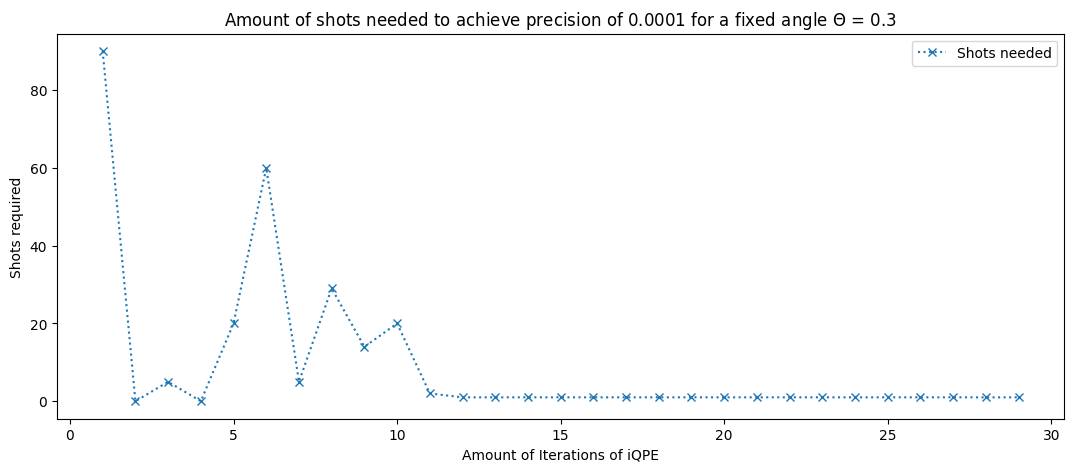

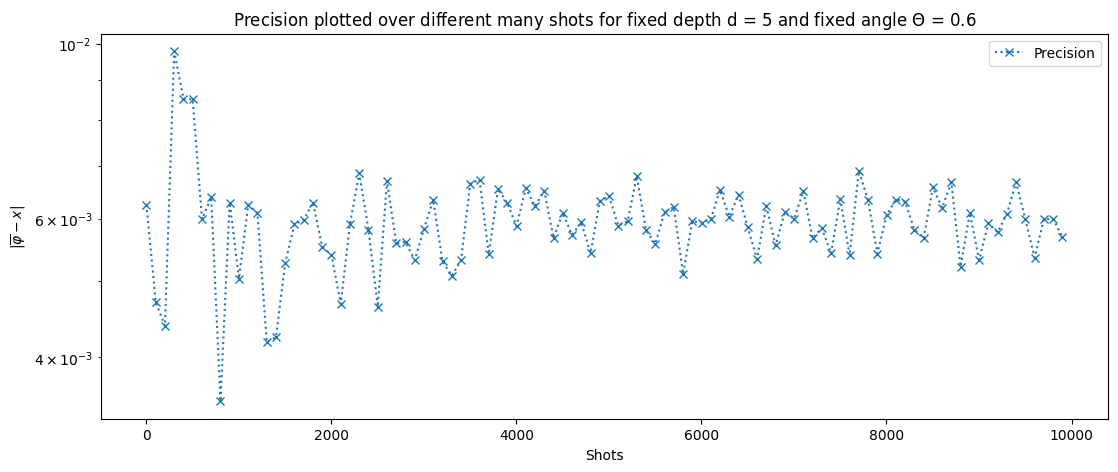

In [65]:
def prec_over_iterations(angle: float, shots:int, maxdepth:int):          #Plottet Präzision in Abh. der Iterations für fixed Winkel/Shotzahl
    list_diff = []
    x = []
    for i in range(1,maxdepth):
        depth = i
        theta = 2*np.pi*angle
        qc = iqpe(theta,depth)

        sim = AerSimulator()
        job = sim.run(qc, shots=int(shots))
        result = job.result()
        counts = result.get_counts()

        keys = counts.keys()
        values = counts.values()

        keys = [convert(i) for i in keys]
        values = [i for i in values]
        avg = mean(keys, values)
        diff = np.abs(avg-angle)
        list_diff.append(diff)

        x.append(i)

    fig, ax = plt.subplots(figsize=(13,5))

    ax = plt.plot(x, list_diff, "x", label="Difference of the mean of measurement to ideal Angle", linestyle = "dotted")
    #ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average

    plt.title("Difference of the measured avg angle compared to the ideal angle over different depths for a fixed angel = {} and {} shots per run".format(angle, int(shots)))
    plt.yscale("log")
    plt.ylabel(r"$\vert \overline{\varphi} - x \vert$")
    plt.xlabel("Amount of Iterations of iQPE")
    return plt.legend()

def plot_shots_per_its(precision: float, depth_range:int, angle: float, maxshots):     #Plotte Shotzahl in Abh. der Iterations für fixed Winkel und fester geforderter Präzision
    list_shots = []
    x = []
    for i in range(1,depth_range):
        depth = i
        theta = 2*np.pi*angle
        qc = iqpe(theta,depth)

        sim = AerSimulator()
        for k in range(1,int(maxshots)):
            job = sim.run(qc, shots=k)
            result = job.result()
            counts = result.get_counts()

            keys = counts.keys()
            values = counts.values()

            keys = [convert(i) for i in keys]
            values = [i for i in values]
            avg = mean(keys, values)
            diff = np.abs(avg-angle)
            if diff <= precision:
                list_shots.append(k)
                break
            elif k==maxshots-1:
                list_shots.append(0)
                break
            else:
                continue

        x.append(i)

    fig, ax = plt.subplots(figsize=(13,5))
    ax = plt.plot(x, list_shots, "x", label="Shots needed", linestyle = "dotted")
    plt.title("Amount of shots needed to achieve precision of {} for a fixed angle ".format(precision)+r"$\Theta$"+" = {}".format(angle))
    #plt.yscale("log")
    plt.ylabel("Shots required")
    plt.xlabel("Amount of Iterations of iQPE")
    plt.legend()

def plot_prec_per_shots(depth: int, start: float, end: float, angle: float, steps: float):
    maxshots = int(end)
    list = []
    x = []
    for k in range(int(start),maxshots, int(steps)):                                
        theta = 2*np.pi*angle
        qc = iqpe(theta,depth)
        sim = AerSimulator()
        job = sim.run(qc, shots=k)
        result = job.result()
        counts = result.get_counts()

        keys = counts.keys()
        values = counts.values()

        keys = [convert(i) for i in keys]
        values = [i for i in values]
        avg = mean(keys, values)
        diff = np.abs(avg-angle)
        list.append(diff)

        x.append(k)
    fig, ax = plt.subplots(figsize=(13,5))

    ax = plt.plot(x, list, "x", label="Precision", linestyle = "dotted")
    #ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average

    plt.title(r"Precision plotted over different many shots for fixed depth d = "+"{} and fixed angle ".format(depth) +r"$\Theta$" + " = {}".format(angle))
    plt.yscale("log")
    plt.ylabel(r"$\vert \overline{\varphi} - x \vert$")
    plt.xlabel("Shots")
    plt.legend()

plot_shots_per_its(1e-4,30,0.3,1e3)

plot_prec_per_shots(5, 1, 1e4, 0.6, 100)
